In [1]:
import os
import numpy as np
import gc
from pathlib import Path

import torch
import lightning as L

# from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.data.datasets.base import SimpleDataset
from minerva.transforms.transform import _Transform
from minerva.data.readers.reader import _Reader
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import Dataset, DataLoader

from typing import List, Optional, Tuple

from matplotlib import pyplot as plt

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


In [2]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

In [3]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

In [4]:
num_classes = 6

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Carregar o modelo salvo
pesos_originais = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"
trained_model = SAMLoRA(
    image_size=255,
    num_classes=5, # considera 6 pois internamente o sam faz +1 pro background
    alpha=1,
    rank=4,
    checkpoint=pesos_originais,
).to(device)

# pesos_pretreinados = "/workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/checkpoints/1-sam-model-2024-11-26-epoch=47-val_loss=0.14.ckpt"
# trained_model = SAMLoRA.load_from_checkpoint(
#     checkpoint_path=pesos_pretreinados,
#     image_size=255,
#     num_classes=num_classes-1, # considera 6 pois internamente o sam faz +1 pro background
#     alpha=1,
#     rank=4,
# ).to(device)

cuda
Focal loss alpha=0.25, will shrink the impact in background


/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

In [5]:
def normalize_data(data, target_min=-1, target_max=1):
    """
    Função responsável por normalizar as imagens no intervalo (-1,1)
    """
    data_min, data_max = data.min(), data.max()
    return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

test_img_reader = [normalize_data(image) for image in TiffReader(Path(train_path) / "test")]
test_label_reader = PNGReader(Path(annotation_path) / "test")

sample_img = test_img_reader[0]
sample_label = test_label_reader[0]

print("shape sample: ", sample_img.shape)
print("shape label: ", sample_label.shape)

shape sample:  (255, 701, 3)
shape label:  (255, 701)


In [6]:
def plot_img_and_label(img, label):
    # Criar a figura com dois subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Exibir a primeira imagem (colorida)
    axes[0].imshow(img)
    axes[0].axis('off')  # Remove os eixos
    axes[0].set_title('Imagem Colorida')

    # Exibir a segunda imagem (escala de cinza)
    axes[1].imshow(label, cmap=label_cmap)
    axes[1].axis('off')  # Remove os eixos
    axes[1].set_title('Imagem Escala de Cinza')

    # Exibir a figura
    plt.tight_layout()
    plt.show()

def plot_label_and_pred(label, pred, points=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(label, cmap=label_cmap)
    axes[0].axis('off')  # Remove os eixos
    axes[0].set_title('Label')

    # Plotar os pontos na label, se fornecidos
    if points is not None:
        for point in points:
            x, y = point
            axes[0].plot(x, y, 'ro', markersize=5)  # 'ro' indica ponto vermelho

    axes[1].imshow(pred, cmap=label_cmap)
    axes[1].axis('off')  # Remove os eixos
    axes[1].set_title('Preds')

    # Exibir a figura
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


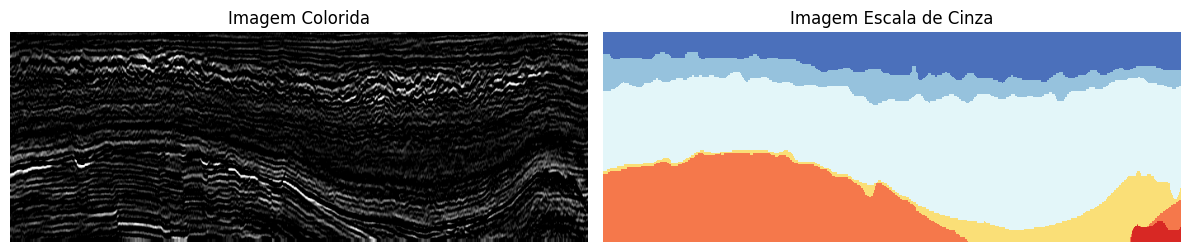

In [7]:
plot_img_and_label(sample_img, sample_label)

In [8]:
def get_points_in_region(region, mask, num_points=4):
    # Obter todas as coordenadas (y, x) da região
    y_indices, x_indices = np.where(mask == region)
    
    # Se não houver pontos na região, retornar uma lista vazia
    if len(y_indices) == 0:
        return []

    # Selecionar pontos equidistantes dentro da região
    num_points = min(num_points, len(y_indices))  # Ajustar o número de pontos se houver menos pixels na região
    indices = np.linspace(0, len(y_indices)-1, num_points, dtype=int)
    selected_y = y_indices[indices]
    selected_x = x_indices[indices]
    
    # Retornar uma lista de tuplas (x, y, valor)
    return list(zip(selected_x, selected_y, [region] * num_points))

In [11]:
def sliding_window_inference(data, label, model, patch_size=255, stride=2, reflection_width=None):
    h, w, _ = data.shape
    preds = np.zeros((h, w))
    counts = np.zeros((h, w))

    # Adiciona reflexão nas bordas (opcional)
    if reflection_width:
        reflected_data = np.pad(data, ((reflection_width, reflection_width), 
                                       (reflection_width, reflection_width), 
                                       (0, 0)), mode='reflect')
    else:
        reflected_data = data
    
    # debug
    # plot_img_and_label(reflected_data, label)

    # Desliza a janela
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch_img = reflected_data[i:i + patch_size, j:j + patch_size]
            patch_label = label[i:i + patch_size, j:j + patch_size]
            # debug
            # plot_label_and_pred(patch_img, patch_label)
            patch_tensor = torch.tensor(patch_img.transpose(2, 0, 1), dtype=torch.float32)  # Reordena para (3, altura, largura)
            patch_tensor = patch_tensor.unsqueeze(0).to(device)  # Adiciona a dimensão do batch, transformando em (1, 3, altura, largura)
            
            # debug
            # print("patch_tensor shape: ", patch_tensor.shape)

            """
            0 - preto
            1 - cinza escuro
            2 - cinza medio
            3 - cinza claro
            4 - cinza branco
            5 - branco
            """
            points = get_points_in_region(0, patch_label, num_points=4)
            points = [[x, y] for (x, y, value) in points]
            labels = [[1] * len(points)]
            points_tensor = torch.tensor(points, dtype=torch.float32)
            points_tensor = points_tensor.unsqueeze(0).unsqueeze(0)
            points_tensor = points_tensor.repeat(1, 1, 1, 1)
            # debug
            print("points: ", points, points_tensor.shape)
            print("labels: ", labels)
            # plot_label_and_pred(patch_img, patch_label, points)
            
            # Previsão do modelo
            outputs = model(patch_tensor, False, image_size=model.image_size)
            probs = torch.softmax(outputs['masks'], dim=1)
            pred = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()

            # debug
            # print(pred.shape)
            # print(outputs['masks'].squeeze().detach().cpu().numpy().shape)
            # print("preds shape: ", preds.shape)
            # plot_label_and_pred(patch_label, pred)
            
            # Soma as predições para a média posterior
            preds[i:i + patch_size, j:j + patch_size] += pred
            counts[i:i + patch_size, j:j + patch_size] += 1

    # debug
    # plot_label_and_pred(label, preds)
    # Retorna a média das predições
    return preds / counts

points:  [[0, 0], [161, 10], [67, 21], [254, 41]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [165, 10], [76, 21], [254, 41]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [170, 10], [85, 21], [254, 41]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [175, 10], [96, 21], [254, 43]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [181, 10], [107, 21], [254, 43]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [187, 10], [119, 21], [254, 45]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [193, 10], [131, 21], [254, 45]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [200, 10], [145, 21], [254, 46]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [206, 10], [158, 21], [254, 46]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [213, 10], [171, 21], [254, 46]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
poin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


points:  [[0, 0], [85, 17], [170, 34], [47, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [81, 17], [163, 34], [46, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [79, 17], [158, 34], [45, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [77, 17], [154, 34], [44, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [75, 17], [150, 34], [43, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [73, 17], [147, 34], [42, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [72, 17], [144, 34], [41, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [71, 17], [142, 34], [40, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [69, 17], [139, 34], [39, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
points:  [[0, 0], [68, 17], [136, 34], [38, 62]] torch.Size([1, 1, 4, 2])
labels:  [[1, 1, 1, 1]]
resultado:  (255, 70

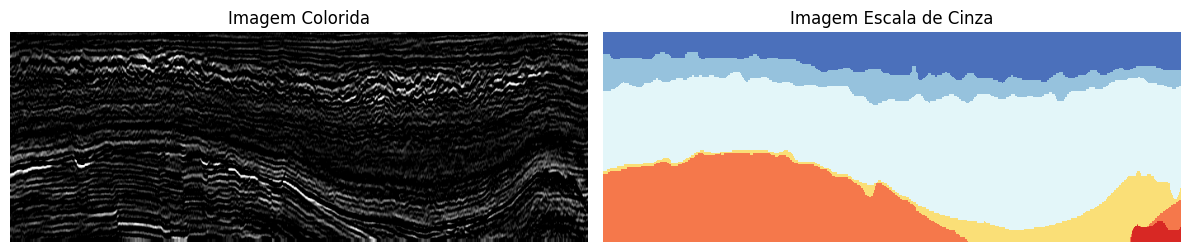

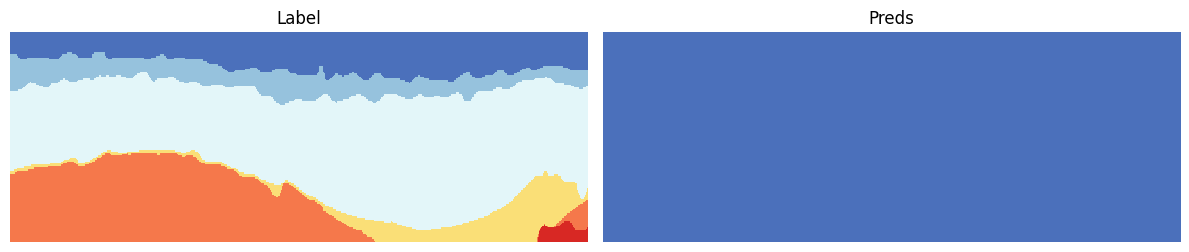

In [12]:
patch_size = 255
stride = 1
reflection_width = 8  # Reflexão nas bordas

resultado = sliding_window_inference(sample_img, sample_label, trained_model, patch_size=patch_size, stride=stride, reflection_width=reflection_width)
print("resultado: ", resultado.shape)
plot_img_and_label(sample_img, sample_label)
plot_label_and_pred(sample_label, resultado)